## Tema 2 AI
### Ilie Andrei-Leonard

Initializam libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
DATASET_TYPE = "simple" # simple, complex
N_SAMPLES = 300
M = 1
EPOCHS = 5

Functii pentru generarea de datasets

In [3]:
def generate_examples(dataset_type = "simple", n_samples = N_SAMPLES, n_features = 1, noise = 20):
    if dataset_type == "simple":
        X, t = datasets.make_regression(n_samples=n_samples, n_features=n_features, n_informative=1, noise=noise, random_state=37)
        return X, t
    
    elif dataset_type == "complex":
        n_samples = 300
        x = np.linspace(-10, 10, n_samples) # coordinates
        noise_sample = np.random.normal(0,0.5,n_samples)
        sine_wave = x + np.sin(4*x) + noise_sample
        return x, sine_wave
    else:
        raise ValueError("Unknown dataset type: " + dataset_type)

Clasa pentru LinearRegression

In [4]:
class LinearRegression(object):
    """
    Modelul de Regresie Liniara
    y = X @ w 
        - valoarea prezisă de model
    t ~ N(t|X @ w, var) 
        - valorile de antrenare (target) sunt fac parte dintr-o distributie normala in jurul mean-ului X@w, 
          la care se adauga zgomot dat de varianta `var`
    """

    def fit(self, X, t):
        """
        Antrenarea modelului in sensul celor mai mici patrate (least squares fitting)
        Parameterii
        ----------
        X : (N, D) np.ndarray
            variabilele de intrare
        t : (N,) np.ndarray
            variabilele tinta (target / ground truth)
        """
        # TODO codul vostru aici: calculati vectorul de ponderi w
        N, D = X.shape
        
        # ar trebui facut cu np.dot sau cu @
        self.w = np.linalg.pinv(X) @ t

        # Calculam variabila din laborator var
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X, return_std=False):
        """
        Intoarce valoari prezise de model pentru sample-uri X
        Parametrii
        ----------
        X : (N, D) np.ndarray
            sample-uri de valori D-dimensionale pentru care se doreste predictia valorii conform modelului
        return_std : bool, optional
            intoarce deviatia standard a fiecarei valori prezice, daca e setat pe True
        
        Intoarce
        -------
        y : (N,) np.ndarray
            vector de valori prezise
        y_std : (N,) np.ndarray
            deviatia standard a fiecarei valori prezise
        """
        # TODO codul vostru aici: calculati valoarea prezisa de modelul vostru
        N, D = X.shape
        y = np.zeros(N)

        y = X @ self.w
        # end codul vostru aici
        
        if return_std:
            # TODO codul vostru aici: intoarceti un vector de aceeasi dimensiune cu y, care 
            # are in fiecare pozitie o valoare egala cu deviatia standard a modelului antrenat (i.e. sqrt(var))
            y_std = np.ones_like(y) * math.sqrt(self.var)

            return y, y_std
        return y

In [5]:
def extract_polynomial_features(X, M):
    phi = X
    # TODO codul vostru aici: intoarceti valorile phi_n astfel incat pentru fiecare 
    # intrare x phi_n = [1, x, x^2, ..., x^M]
    phi_n = np.zeros((X.size, M+1))

    print(X[0])

    for i in range(X.size):
        current = np.zeros(M+1)

        for j in range(M+1):
            current[j] = X[i] ** j

        phi_n[i] = current
        # print(X[i][0], i)

    phi = phi_n
    # end
    
    # nota: phi trebuie sa fie la final un np.array de dimensiune (N, M+1), unde N este numarul de linii din X
    return phi


In [6]:
# Functia de eroare conform PDF
def mean_squared_error(y, t):
    return np.mean((y - t) * (y- t))

## 1.1. Solutia in forma inchisa

In [7]:
# Generam datele de test si train
# Folosind proportia 20/80 
X, t = generate_examples(dataset_type=DATASET_TYPE)
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=42)

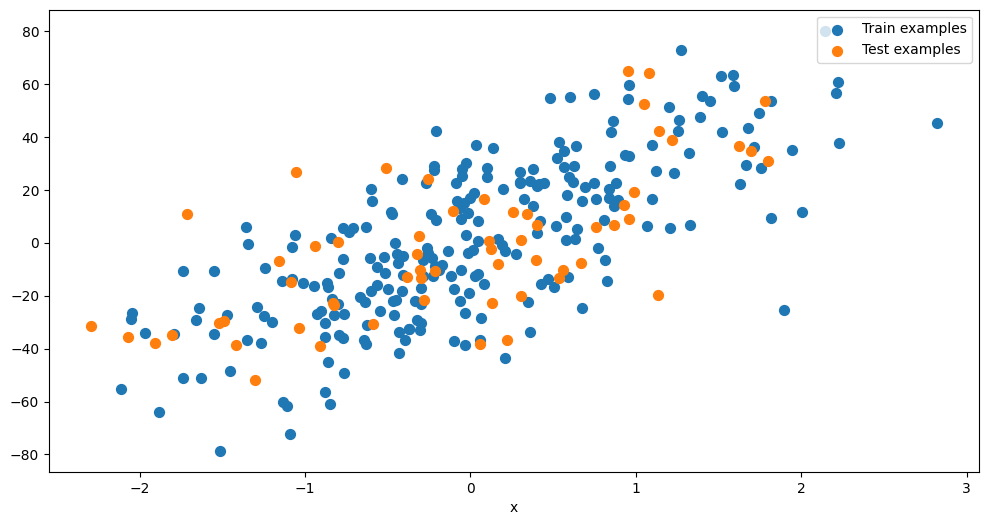

In [8]:
plt.figure(figsize=(12,6))
plt.scatter(X_train, t_train, s=50, label="Train examples")
plt.scatter(X_test, t_test, s=50, label="Test examples")
plt.xlabel("x")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()

In [9]:
# creati un model liniar
model = LinearRegression()

# Folositi functia extract_polynomial_features pentru a introduce termenul de bias in matricile X_train si X_test
X_train_feat = extract_polynomial_features(X_train, M)
X_test_feat = extract_polynomial_features(X_test, M)

# antrenati modelul vostru
model.fit(X_train_feat, t_train)

# obtineti predictia pe setul de antrenare si pe setul de test
y_train = model.predict(X_train_feat) 
y_train = np.zeros(X_train.size)
y_test = np.zeros(X_test.size)
y_test_std = np.zeros(X_test.size)
y_test, y_test_std = model.predict(X_test_feat, True)

# Sortam
sorted_stuffs = list(zip(*sorted(zip(X_test,y_test))))
X_test_sorted = sorted_stuffs[0]
y_test_sorted = sorted_stuffs[1]

[0.32516501]
[0.13005544]


In [10]:
print("Train error:", mean_squared_error(y_train, t_train))
print("Test  error:", mean_squared_error(y_test, t_test))

Train error: 923.3620667511971
Test  error: 441.0678181565175


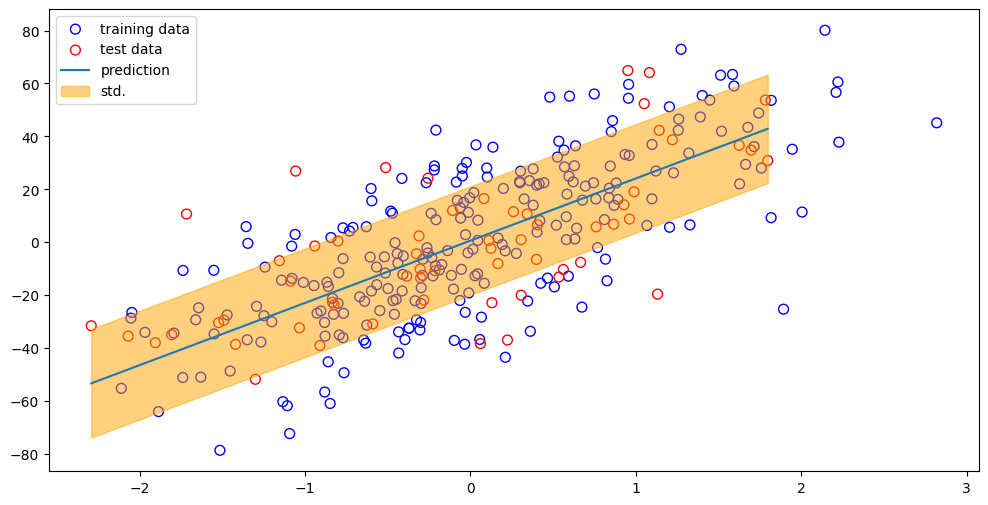

In [11]:
plt.figure(figsize=(12,6))
plt.scatter(X_train, t_train, facecolor="none", color="b", s=50, label="training data")
plt.scatter(X_test, t_test, facecolor="none", color="r", s=50, label="test data")
plt.plot(X_test_sorted, y_test_sorted, label="prediction")
plt.fill_between(
    np.squeeze(X_test_sorted), y_test_sorted - y_test_std, y_test_sorted + y_test_std,
    color="orange", alpha=0.5, label="std.")
plt.legend()
plt.show()

## 1.2. Gradient Descent

In [12]:
def gradient_descent(X, t, epochs, eta):
    w = np.random.randn(X.shape[1]) * 0.01


    risks = [] # store risks for each epoch
    function_values = [] # store function values for each epoch
    errors = []


    for epoch in range(epochs):
        y = np.dot(X, w) # calculate output

        error = y - t # calculate error
        errors.append(error)

        
        gradient = np.dot(X.T, error) / len(X) # calculate gradient
        w -= eta * gradient # update weights

        risk = np.mean(error ** 2) / 2 # calculate risk
        risks.append(risk)
        
        function_value = np.mean((y - t) ** 2) / 2 # calculate function value
        function_values.append(function_value)

    return w, risks, function_values
    
class GradientDescent(object):

    def fit(self, X, t, epochs, eta):
        """
        Antrenarea modelului in sensul celor mai mici patrate (least squares fitting)
        Parameterii
        ----------
        X : (N, D) np.ndarray
            variabilele de intrare
        t : (N,) np.ndarray
            variabilele tinta (target / ground truth)
        """
        # TODO codul vostru aici: calculati vectorul de ponderi w
        # print(X.shape)
        N, D = X.shape

        self.w, self.risks, self.function_values = gradient_descent(X, t, epochs, eta)
        
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X, return_std=False):
        """
        Intoarce valoari prezise de model pentru sample-uri X
        Parametrii
        ----------
        X : (N, D) np.ndarray
            sample-uri de valori D-dimensionale pentru care se doreste predictia valorii conform modelului
        return_std : bool, optional
            intoarce deviatia standard a fiecarei valori prezice, daca e setat pe True
        
        Intoarce
        -------
        y : (N,) np.ndarray
            vector de valori prezise
        y_std : (N,) np.ndarray
            deviatia standard a fiecarei valori prezise
        """
        # TODO codul vostru aici: calculati valoarea prezisa de modelul vostru
        N, D = X.shape
        y = np.zeros(N)

        y = X @ self.w
        # end codul vostru aici
        
        if return_std:
            # TODO codul vostru aici: intoarceti un vector de aceeasi dimensiune cu y, care 
            # are in fiecare pozitie o valoare egala cu deviatia standard a modelului antrenat (i.e. sqrt(var))
            y_std = np.ones_like(y) * math.sqrt(self.var)

            # aplic sqrt(var) pe toti y
            return y, y_std
        return y

In [13]:
# creati un model liniar
# model = ...
model_gradient = GradientDescent()

# epochs = 5
eta = 0.05

# Folositi functia extract_polynomial_features pentru a introduce termenul de bias in matricile X_train si X_test
X_train_feat_gradient = extract_polynomial_features(X_train, M)
X_test_feat_gradient = extract_polynomial_features(X_test, M)

# antrenati modelul vostru
model_gradient.fit(X_train_feat_gradient, t_train, EPOCHS, eta)

# obtineti predictia pe setul de antrenare si pe setul de test
y_train_gradient = model_gradient.predict(X_train_feat_gradient) 
y_train_gradient = np.zeros(X_train.size)
y_test_gradient = np.zeros(X_test.size)
y_test_std_gradient = np.zeros(X_test.size)
y_test_gradient, y_test_std_gradient = model_gradient.predict(X_test_feat_gradient, True)

# Sortam
sorted_stuffs = list(zip(*sorted(zip(X_test,y_test_gradient))))
X_test_sorted_gradient = sorted_stuffs[0]
y_test_sorted_gradient = sorted_stuffs[1]


[0.32516501]
[0.13005544]


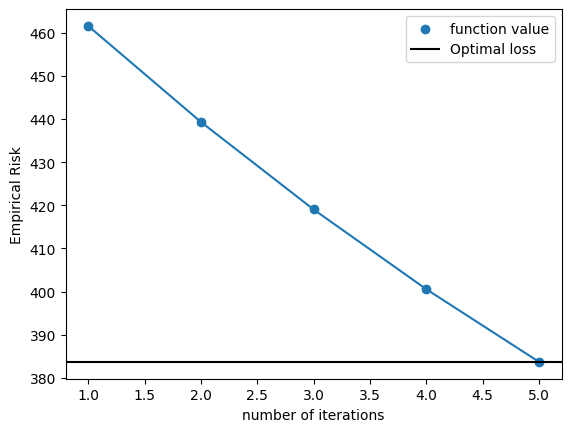

In [14]:
# w, risks, function_values = gradient_descent(X_train, t_train, epochs, eta)
plt.plot(range(1, EPOCHS+1), model_gradient.risks)
plt.scatter(range(1, EPOCHS+1), model_gradient.function_values, label='function value')
plt.axhline(y=min(model_gradient.risks), color='black', linestyle='-', label='Optimal loss')
plt.xlabel('number of iterations')
plt.ylabel('Empirical Risk')
plt.legend()
plt.show()

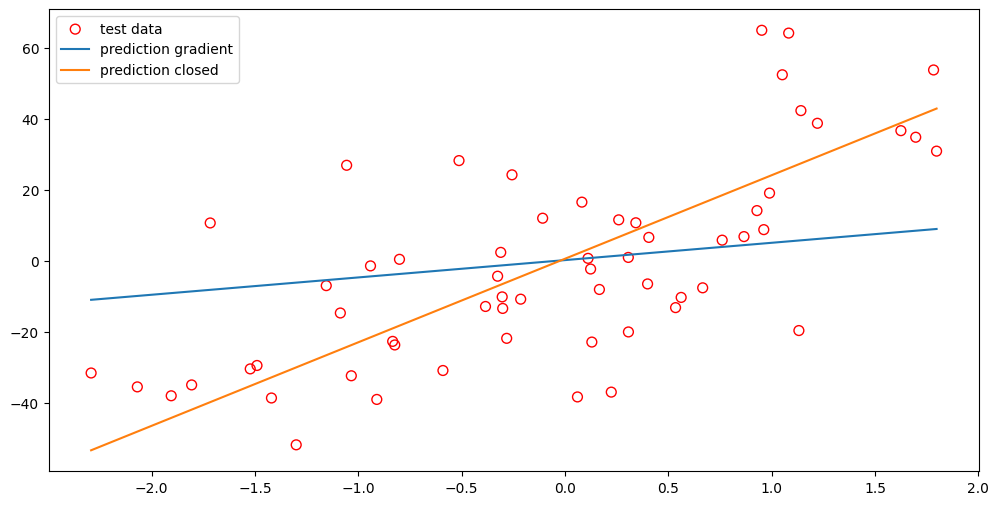

In [15]:
plt.figure(figsize=(12,6))
# plt.scatter(X_train, t_train, facecolor="none", color="b", s=50, label="training data")
plt.scatter(X_test, t_test, facecolor="none", color="r", s=50, label="test data")
plt.plot(X_test_sorted_gradient, y_test_sorted_gradient, label="prediction gradient")
plt.plot(X_test_sorted, y_test_sorted, label="prediction closed")
plt.legend()
plt.show()

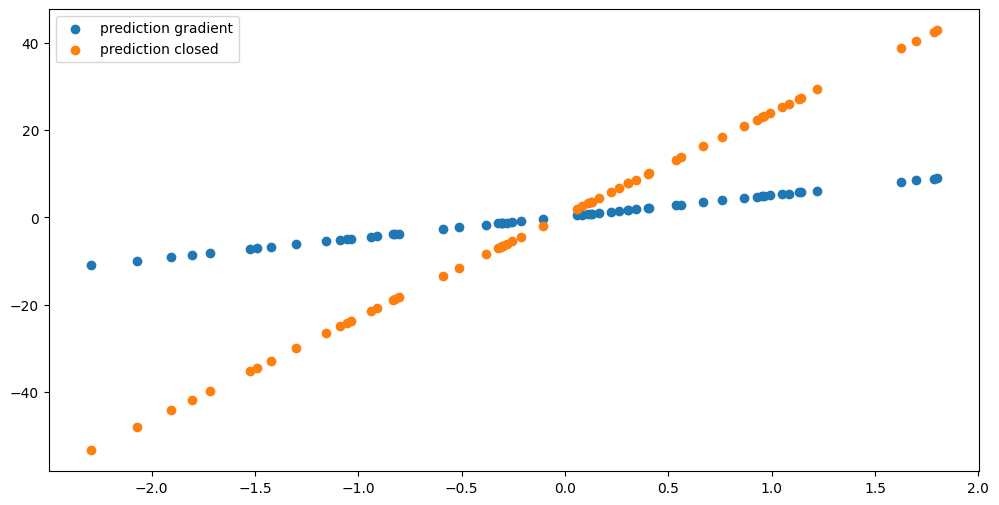

In [16]:
plt.figure(figsize=(12,6))
# plt.scatter(X_train, t_train, facecolor="none", color="b", s=50, label="training data")
# plt.scatter(X_test, t_test, facecolor="none", color="r", s=50, label="test data")
plt.scatter(X_test_sorted_gradient, y_test_sorted_gradient, label="prediction gradient")
plt.scatter(X_test_sorted, y_test_sorted, label="prediction closed")
plt.legend()
plt.show()

In [17]:
print("Train error:// CLOSED ", mean_squared_error(y_train, t_train))
print("Test  error:// CLOSED ", mean_squared_error(y_test, t_test))

print("Train error:// GRADIENT ", mean_squared_error(y_train_gradient, t_train))
print("Test  error:// GRADIENT ", mean_squared_error(y_test_gradient, t_test))

Train error:// CLOSED  923.3620667511971
Test  error:// CLOSED  441.0678181565175
Train error:// GRADIENT  923.3620667511971
Test  error:// GRADIENT  602.066405598795


# 1.3. Mini-Batch Gradient Descent

In [18]:
def gradient_descent_minibatch(X, t, epochs, eta, batch_size):
    w = np.random.randn(X.shape[1]) * 0.01

    risks = [] # store risks for each epoch
    function_values = [] # store function values for each epoch
    errors = []

    n_batches = int(np.ceil(X.shape[0] / batch_size))

    print(n_batches)

    for epoch in range(epochs):

        for batch in range(n_batches):

            current_x = X[batch*batch_size:(batch+1)*batch_size]

            y = np.dot(X, w)[batch*batch_size:(batch+1)*batch_size] # calculate output

            error = y - t[batch*batch_size:(batch+1)*batch_size] # calculate error
            errors.append(error)

            gradient = np.dot(current_x.T, error) / len(current_x) # calculate gradient
            w -= eta * gradient # update weights

            risk = np.mean(error ** 2) / 2 # calculate risk
            risks.append(risk)
            
            function_value = np.mean((y - t[batch*batch_size:(batch+1)*batch_size]) ** 2) / 2 # calculate function value
            function_values.append(function_value)

    return w, risks, function_values
    
class GradientDescentMiniBatch(object):

    def fit(self, X, t, epochs, eta, batch_size):
        """
        Antrenarea modelului in sensul celor mai mici patrate (least squares fitting)
        Parameterii
        ----------
        X : (N, D) np.ndarray
            variabilele de intrare
        t : (N,) np.ndarray
            variabilele tinta (target / ground truth)
        """
        # TODO codul vostru aici: calculati vectorul de ponderi w
        # print(X.shape)
        N, D = X.shape

        self.w, self.risks, self.function_values = gradient_descent_minibatch(X, t, epochs, eta, batch_size)
        
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X, return_std=False):
        """
        Intoarce valoari prezise de model pentru sample-uri X
        Parametrii
        ----------
        X : (N, D) np.ndarray
            sample-uri de valori D-dimensionale pentru care se doreste predictia valorii conform modelului
        return_std : bool, optional
            intoarce deviatia standard a fiecarei valori prezice, daca e setat pe True
        
        Intoarce
        -------
        y : (N,) np.ndarray
            vector de valori prezise
        y_std : (N,) np.ndarray
            deviatia standard a fiecarei valori prezise
        """
        # TODO codul vostru aici: calculati valoarea prezisa de modelul vostru
        N, D = X.shape
        y = np.zeros(N)

        y = X @ self.w
        # end codul vostru aici
        
        if return_std:
            # TODO codul vostru aici: intoarceti un vector de aceeasi dimensiune cu y, care 
            # are in fiecare pozitie o valoare egala cu deviatia standard a modelului antrenat (i.e. sqrt(var))
            y_std = np.ones_like(y) * math.sqrt(self.var)

            # aplic sqrt(var) pe toti y
            return y, y_std
        return y

In [19]:
# creati un model liniar
# model = ...
model_gradient_minibatch  = GradientDescentMiniBatch()

# epochs = 50
eta = 0.05
batch_size = 150

# Folositi functia extract_polynomial_features pentru a introduce termenul de bias in matricile X_train si X_test
X_train_feat_gradient_minibatch = extract_polynomial_features(X_train, M)
X_test_feat_gradient_minibatch  = extract_polynomial_features(X_test, M)

# antrenati modelul vostru
model_gradient_minibatch.fit(X_train_feat_gradient_minibatch, t_train, EPOCHS, eta, batch_size)

# obtineti predictia pe setul de antrenare si pe setul de test
y_train_gradient_minibatch = model_gradient_minibatch.predict(X_train_feat_gradient_minibatch) 
y_train_gradient_minibatch = np.zeros(X_train.size)
y_test_gradient_minibatch = np.zeros(X_test.size)
y_test_std_gradient_minibatch = np.zeros(X_test.size)
y_test_gradient_minibatch, y_test_std_gradient_minibatch = model_gradient_minibatch.predict(X_test_feat_gradient_minibatch, True)

# Sortam
sorted_stuffs = list(zip(*sorted(zip(X_test,y_test_gradient_minibatch))))
X_test_sorted_gradient_minibatch = sorted_stuffs[0]
y_test_sorted_gradient_minibatch = sorted_stuffs[1]


[0.32516501]
[0.13005544]
2


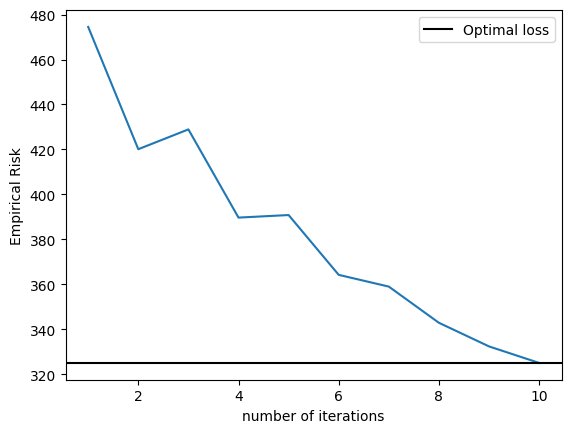

In [20]:
# w, risks, function_values = gradient_descent(X_train, t_train, epochs, eta)
plt.plot(range(1, 1 + EPOCHS*int(np.ceil(X_train_feat_gradient_minibatch.shape[0] / batch_size))), model_gradient_minibatch.risks)
# plt.scatter(range(1, 1 +epochs*int(X_train_feat_gradient_minibatch.shape[0]/batch_size)), model_gradient_minibatch.function_values, label='function value')
plt.axhline(y=min(model_gradient_minibatch.risks), color='black', linestyle='-', label='Optimal loss')
plt.xlabel('number of iterations')
plt.ylabel('Empirical Risk')
plt.legend()
plt.show()

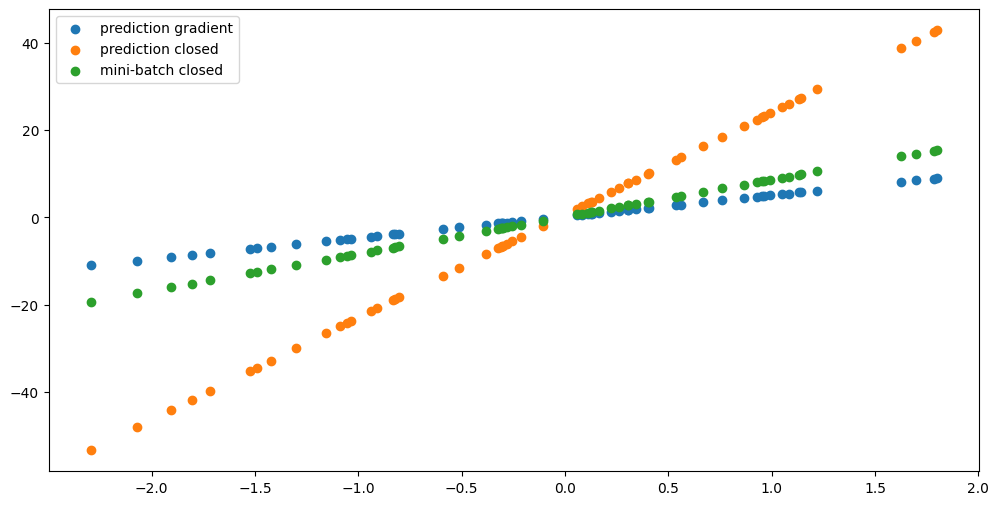

In [21]:
plt.figure(figsize=(12,6))
# plt.scatter(X_train, t_train, facecolor="none", color="b", s=50, label="training data")
# plt.scatter(X_test, t_test, facecolor="none", color="r", s=50, label="test data")
plt.scatter(X_test_sorted_gradient, y_test_sorted_gradient, label="prediction gradient")
plt.scatter(X_test_sorted, y_test_sorted, label="prediction closed")
plt.scatter(X_test_sorted_gradient_minibatch, y_test_sorted_gradient_minibatch, label="mini-batch closed")

plt.legend()
plt.show()

In [22]:
def gradient_descent_stochastic(X, t, epochs, eta):
    w = np.random.randn(X.shape[1]) * 0.01

    risks = [] # store risks for each epoch
    function_values = [] # store function values for each epoch
    errors = []
    batch_size = 1

    n_batches = int(np.ceil(X.shape[0] / batch_size))

    print(n_batches)

    for epoch in range(epochs):

        X, t = shuffle(X, t)

        for batch in range(n_batches):

            current_x = X[batch*batch_size:(batch+1)*batch_size]

            y = np.dot(X, w)[batch*batch_size:(batch+1)*batch_size] # calculate output

            error = y - t[batch*batch_size:(batch+1)*batch_size] # calculate error
            errors.append(error)

            gradient = np.dot(current_x.T, error) / len(current_x) # calculate gradient
            w -= eta * gradient # update weights

            risk = np.mean(error ** 2) / 2 # calculate risk
            risks.append(risk)
            
            function_value = np.mean((y - t[batch*batch_size:(batch+1)*batch_size]) ** 2) / 2 # calculate function value
            function_values.append(function_value)

    return w, risks, function_values
    
class GradientDescentStochastic(object):

    def fit(self, X, t, epochs, eta):
        """
        Antrenarea modelului in sensul celor mai mici patrate (least squares fitting)
        Parameterii
        ----------
        X : (N, D) np.ndarray
            variabilele de intrare
        t : (N,) np.ndarray
            variabilele tinta (target / ground truth)
        """
        # TODO codul vostru aici: calculati vectorul de ponderi w
        # print(X.shape)
        N, D = X.shape

        self.w, self.risks, self.function_values = gradient_descent_stochastic(X, t, epochs, eta)
        
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X, return_std=False):
        """
        Intoarce valoari prezise de model pentru sample-uri X
        Parametrii
        ----------
        X : (N, D) np.ndarray
            sample-uri de valori D-dimensionale pentru care se doreste predictia valorii conform modelului
        return_std : bool, optional
            intoarce deviatia standard a fiecarei valori prezice, daca e setat pe True
        
        Intoarce
        -------
        y : (N,) np.ndarray
            vector de valori prezise
        y_std : (N,) np.ndarray
            deviatia standard a fiecarei valori prezise
        """
        # TODO codul vostru aici: calculati valoarea prezisa de modelul vostru
        N, D = X.shape
        y = np.zeros(N)

        y = X @ self.w
        # end codul vostru aici
        
        if return_std:
            # TODO codul vostru aici: intoarceti un vector de aceeasi dimensiune cu y, care 
            # are in fiecare pozitie o valoare egala cu deviatia standard a modelului antrenat (i.e. sqrt(var))
            y_std = np.ones_like(y) * math.sqrt(self.var)

            # aplic sqrt(var) pe toti y
            return y, y_std
        return y

In [23]:
# creati un model liniar
# model = ...
model_gradient_stochastic  = GradientDescentStochastic()

epochs = 5
eta = 0.05

# Folositi functia extract_polynomial_features pentru a introduce termenul de bias in matricile X_train si X_test
X_train_feat_gradient_stochastic = extract_polynomial_features(X_train, M)
X_test_feat_gradient_stochastic  = extract_polynomial_features(X_test, M)

# antrenati modelul vostru
model_gradient_stochastic.fit(X_train_feat_gradient_stochastic, t_train, epochs, eta)

# obtineti predictia pe setul de antrenare si pe setul de test
y_train_gradient_stochastic = model_gradient_stochastic.predict(X_train_feat_gradient_stochastic) 
y_train_gradient_stochastic = np.zeros(X_train.size)
y_test_gradient_stochastic = np.zeros(X_test.size)
y_test_std_gradient_stochastic = np.zeros(X_test.size)
y_test_gradient_stochastic, y_test_std_gradient_stochastic = model_gradient_stochastic.predict(X_test_feat_gradient_stochastic, True)

# Sortam
sorted_stuffs = list(zip(*sorted(zip(X_test,y_test_gradient_stochastic))))
X_test_sorted_gradient_stochastic = sorted_stuffs[0]
y_test_sorted_gradient_stochastic = sorted_stuffs[1]


[0.32516501]
[0.13005544]
240


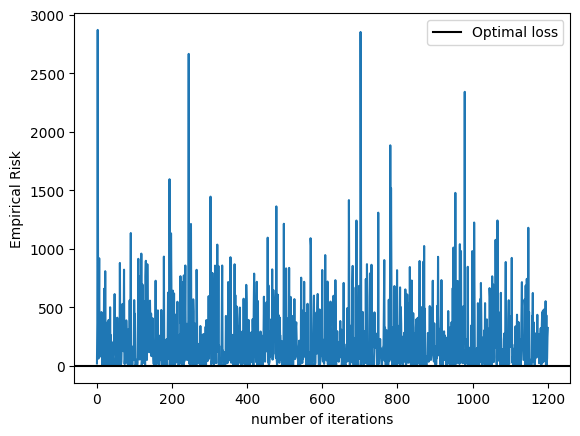

In [24]:
# w, risks, function_values = gradient_descent(X_train, t_train, epochs, eta)
plt.plot(range(1, 1 + epochs*int(X_train_feat_gradient_stochastic.shape[0])), model_gradient_stochastic.risks)
plt.axhline(y=min(model_gradient_stochastic.risks), color='black', linestyle='-', label='Optimal loss')
# plt.scatter(range(1, 1 +epochs*int(X_train_feat_gradient_minibatch.shape[0]/batch_size)), model_gradient_minibatch.function_values, label='function value')
plt.xlabel('number of iterations')
plt.ylabel('Empirical Risk')
plt.legend()
plt.show()

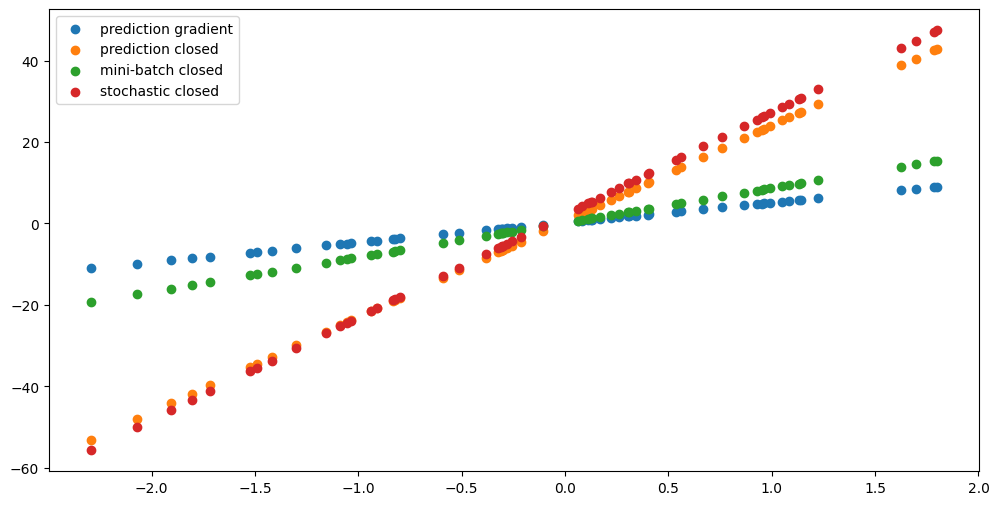

In [25]:
plt.figure(figsize=(12,6))
# plt.scatter(X_train, t_train, facecolor="none", color="b", s=50, label="training data")
# plt.scatter(X_test, t_test, facecolor="none", color="r", s=50, label="test data")
plt.scatter(X_test_sorted_gradient, y_test_sorted_gradient, label="prediction gradient")
plt.scatter(X_test_sorted, y_test_sorted, label="prediction closed")
plt.scatter(X_test_sorted_gradient_minibatch, y_test_sorted_gradient_minibatch, label="mini-batch closed")
plt.scatter(X_test_sorted_gradient_stochastic, y_test_sorted_gradient_stochastic, label="stochastic closed")

plt.legend()
plt.show()